### **Pyspark Regression Analysis**

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import numpy as np

In [2]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array

# **Part 1: Data Exploration and Cleaning**

### 1. Data Loading and Inspection

- Load the dataset and display the first five rows.
- Rename the columns for better understanding as follows:
  - 'carat' → 'Carat'
  - 'cut' → 'Cut'
  - 'color' → 'Color'
  - 'clarity' → 'Clarity'
  - 'depth' → 'Depth'
  - 'table' → 'Table_percent'
  - 'x' → 'Length'
  - 'y' → 'Width'
  - 'z' → 'Height'
  - 'price' → 'Price'


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DiamondsDataAnalysis") \
    .getOrCreate()

df = spark.read.csv("cubic_zirconia.csv", header=True, inferSchema=True)

# Display the first five rows
df.show(5)
display(df.toPandas().head(5))
df = df.drop('_c0')

24/10/27 20:41:18 WARN Utils: Your hostname, Mukunds-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.149 instead (on interface en0)
24/10/27 20:41:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/27 20:41:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/27 20:41:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , carat, cut, color, clarity, depth, table, x, y, z, price
 Schema: _c0, carat, cut, color, clarity, depth, table, x, y, z, price
Expected: _c0 but found: 
CSV file: file:///Users/mukundkomati/Documents/big_data_applications/hands_on_pyspark/cubic_zirconia.csv
24/10/27 20:41:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , carat, cut, color, clarity, d

+---+-----+---------+-----+-------+-----+-----+----+----+----+-----+
|_c0|carat|      cut|color|clarity|depth|table|   x|   y|   z|price|
+---+-----+---------+-----+-------+-----+-----+----+----+----+-----+
|  1|  0.3|    Ideal|    E|    SI1| 62.1| 58.0|4.27|4.29|2.66|  499|
|  2| 0.33|  Premium|    G|     IF| 60.8| 58.0|4.42|4.46| 2.7|  984|
|  3|  0.9|Very Good|    E|   VVS2| 62.2| 60.0|6.04|6.12|3.78| 6289|
|  4| 0.42|    Ideal|    F|    VS1| 61.6| 56.0|4.82| 4.8|2.96| 1082|
|  5| 0.31|    Ideal|    F|   VVS1| 60.4| 59.0|4.35|4.43|2.65|  779|
+---+-----+---------+-----+-------+-----+-----+----+----+----+-----+
only showing top 5 rows



,_c0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.10,58.00,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.80,58.00,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.20,60.00,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.60,56.00,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.40,59.00,4.35,4.43,2.65,779


In [4]:
# Rename columns for better understanding
df = df.withColumnRenamed("carat", "Carat") \
       .withColumnRenamed("cut", "Cut") \
       .withColumnRenamed("color", "Color") \
       .withColumnRenamed("clarity", "Clarity") \
       .withColumnRenamed("depth", "Depth_percent") \
       .withColumnRenamed("table", "Table_percent") \
       .withColumnRenamed("x", "Length") \
       .withColumnRenamed("y", "Width") \
       .withColumnRenamed("z", "Height") \
       .withColumnRenamed("price", "Price")

# Display the updated dataframe with renamed columns
df.show(5)



+-----+---------+-----+-------+-------------+-------------+------+-----+------+-----+
|Carat|      Cut|Color|Clarity|Depth_percent|Table_percent|Length|Width|Height|Price|
+-----+---------+-----+-------+-------------+-------------+------+-----+------+-----+
|  0.3|    Ideal|    E|    SI1|         62.1|         58.0|  4.27| 4.29|  2.66|  499|
| 0.33|  Premium|    G|     IF|         60.8|         58.0|  4.42| 4.46|   2.7|  984|
|  0.9|Very Good|    E|   VVS2|         62.2|         60.0|  6.04| 6.12|  3.78| 6289|
| 0.42|    Ideal|    F|    VS1|         61.6|         56.0|  4.82|  4.8|  2.96| 1082|
| 0.31|    Ideal|    F|   VVS1|         60.4|         59.0|  4.35| 4.43|  2.65|  779|
+-----+---------+-----+-------+-------------+-------------+------+-----+------+-----+
only showing top 5 rows



### 2. Dataset Overview

- Report the size of the dataset (number of rows and columns).
- Display the data types for each column.
- Show unique values present in the `Cut`, `Color`, and `Clarity` columns.


In [5]:
# 2. Dataset Overview
# Report the size of the dataset (number of rows and columns)
row_count = df.count()
column_count = len(df.columns)
print(f"Dataset size: {row_count} rows and {column_count} columns")

# Display data types for each column
df.printSchema()

# Show unique values present in the 'Cut', 'Color', and 'Clarity' columns
df.select("Cut").distinct().show()
df.select("Color").distinct().show()
df.select("Clarity").distinct().show()

Dataset size: 26967 rows and 10 columns
root
 |-- Carat: double (nullable = true)
 |-- Cut: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Clarity: string (nullable = true)
 |-- Depth_percent: double (nullable = true)
 |-- Table_percent: double (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Price: integer (nullable = true)

+---------+
|      Cut|
+---------+
|  Premium|
|    Ideal|
|     Good|
|     Fair|
|Very Good|
+---------+

+-----+
|Color|
+-----+
|    F|
|    E|
|    D|
|    J|
|    G|
|    I|
|    H|
+-----+

+-------+
|Clarity|
+-------+
|   VVS2|
|    SI1|
|     IF|
|     I1|
|   VVS1|
|    VS2|
|    SI2|
|    VS1|
+-------+



# **Part 2: Data Cleaning and Summary Statistics**

## 1. Handling Missing Data

- Identify and handle any missing or null values in the dataset. Provide an explanation of the approach you used.

Median imputation is performed here for the following reasons:

- **Robustness to Outliers**: It is less sensitive to extreme values compared to mean imputation.
- **Preserves Distribution Shape**: Maintains the data distribution better, especially for skewed data.
- **Simplicity**: Easy to calculate and understand.
- **Reduces Bias**: Helps avoid biases introduced by mean imputation.

In contrast, other methods like mean or mode imputation can distort data or fail to provide meaningful insights. Thus, median imputation is often more reliable.


In [6]:
#identifying missing values
df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df.columns]).show()

+-----+---+-----+-------+-------------+-------------+------+-----+------+-----+
|Carat|Cut|Color|Clarity|Depth_percent|Table_percent|Length|Width|Height|Price|
+-----+---+-----+-------+-------------+-------------+------+-----+------+-----+
|    0|  0|    0|      0|          697|            0|     0|    0|     0|    0|
+-----+---+-----+-------+-------------+-------------+------+-----+------+-----+



In [7]:
median_value = df.approxQuantile("Depth_percent", [0.5], 0.01)[0]
median_value

61.8

In [8]:
#handling missing values by imputing the median
df = df.fillna({"Depth_percent": median_value})

In [9]:
df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df.columns]).show()

+-----+---+-----+-------+-------------+-------------+------+-----+------+-----+
|Carat|Cut|Color|Clarity|Depth_percent|Table_percent|Length|Width|Height|Price|
+-----+---+-----+-------+-------------+-------------+------+-----+------+-----+
|    0|  0|    0|      0|            0|            0|     0|    0|     0|    0|
+-----+---+-----+-------+-------------+-------------+------+-----+------+-----+



## 2. Descriptive Statistics

- For numerical columns, provide a statistical summary, including minimum, maximum, variance, and standard deviation.
- Identify and analyze potential outliers in the data and explain how they will be treated.

In [10]:
num_cols = [field.name for field in df.schema.fields if field.dataType.typeName() != 'string']
num_cols.remove('Price')

In [11]:
num_cols

['Carat', 'Depth_percent', 'Table_percent', 'Length', 'Width', 'Height']

In [12]:
var_describe = df.select([F.var_pop(F.col(x)).alias(x) for x in num_cols])\
                .withColumn('summary', F.lit("var"))\
                .select(['summary'] + num_cols)
other_describe = df.select(num_cols).describe()\
.filter(F.col('summary').isin(['mean', 'min', 'max', 'stddev']))
stat_report = other_describe.union(var_describe)
stat_report.show()
stat_report.toPandas()

24/10/27 20:41:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|              Carat|     Depth_percent|     Table_percent|            Length|            Width|            Height|
+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|   mean| 0.7983754218118336| 61.74656431935459| 57.45607965290908| 5.729853524678309|5.733568806318799|3.5380572551637184|
| stddev|0.47774547354501784| 1.394508507861608|2.2320679090295186|1.1285163776477662|1.166057529926046| 0.720623625642771|
|    min|                0.2|              50.8|              49.0|               0.0|              0.0|               0.0|
|    max|                4.5|              73.6|              79.0|             10.23|             58.9|              31.8|
|    var| 0.2282322737875769|1.9445818661396552| 4.981942401487237|1.2735019884088814|1.359639742577222|0.5192791530239926|
+-------

,summary,Carat,Depth_percent,Table_percent,Length,Width,Height
0,mean,0.7983754218118336,61.74656431935459,57.45607965290908,5.729853524678309,5.733568806318799,3.5380572551637184
1,stddev,0.47774547354501784,1.394508507861608,2.2320679090295186,1.1285163776477662,1.166057529926046,0.720623625642771
2,min,0.2,50.8,49.0,0.0,0.0,0.0
3,max,4.5,73.6,79.0,10.23,58.9,31.8
4,var,0.2282322737875769,1.9445818661396552,4.981942401487237,1.2735019884088814,1.359639742577222,0.5192791530239926


### Identify and analyze potential outliers in the data and explain how they will be treated.

In [13]:
#function to find outlier percentage
def get_outliers_per(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3-q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    res = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound))
    return 100 * res.count() / df.count()

#function for plotting outliers
def plot_outliers(df, col_names):
    n_cols = 3  # Number of columns in the subplot
    n_rows = (len(col_names) + n_cols - 1) // n_cols  # Calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), constrained_layout=True)

    axes = axes.flatten()

    for i, col_name in enumerate(col_names):
        outlier_per = get_outliers_per(df, col_name)
        pandas_df = df.select(col_name).toPandas()  # Convert to pandas DataFrame
        sns.boxplot(x=pandas_df[col_name], ax=axes[i])  # Create box plot on the respective subplot
        axes[i].set_title("Box Plot of {a} (Outlier % : {b:.2f})".format(a=col_name, b=outlier_per))

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

#function for replacing outliers with median
def replace_outliers_median(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    median = df.approxQuantile(col_name, [0.5], 0.01)[0]
    iqr = q3-q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    res = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound))

    df = df.withColumn(col_name, F.when((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound), median)\
                       .otherwise(F.col(col_name)))
    
    return df

#function for replacing outliers with capping
def replace_outliers_capping(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    median = df.approxQuantile(col_name, [0.5], 0.01)[0]
    iqr = q3-q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    res = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound))

    df = df.withColumn(col_name, F.when((F.col(col_name) < lower_bound), lower_bound)\
                       .otherwise(F.col(col_name)))
    df = df.withColumn(col_name, F.when((F.col(col_name) > upper_bound), upper_bound)\
                       .otherwise(F.col(col_name)))
    return df

#### Box plot to identify outliers

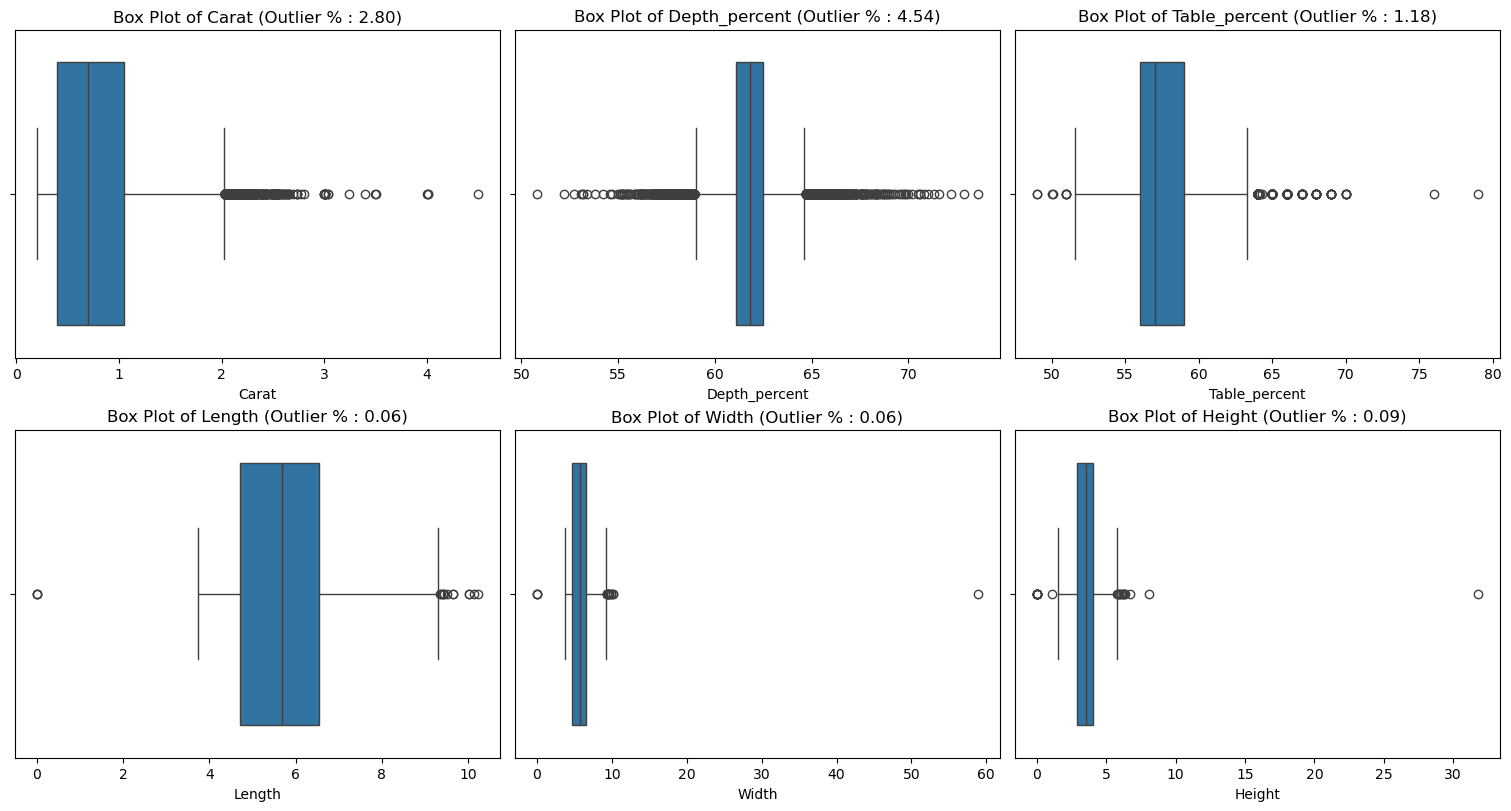

In [14]:
plot_outliers(df, num_cols)

#### Histogram plots to analyse distribution

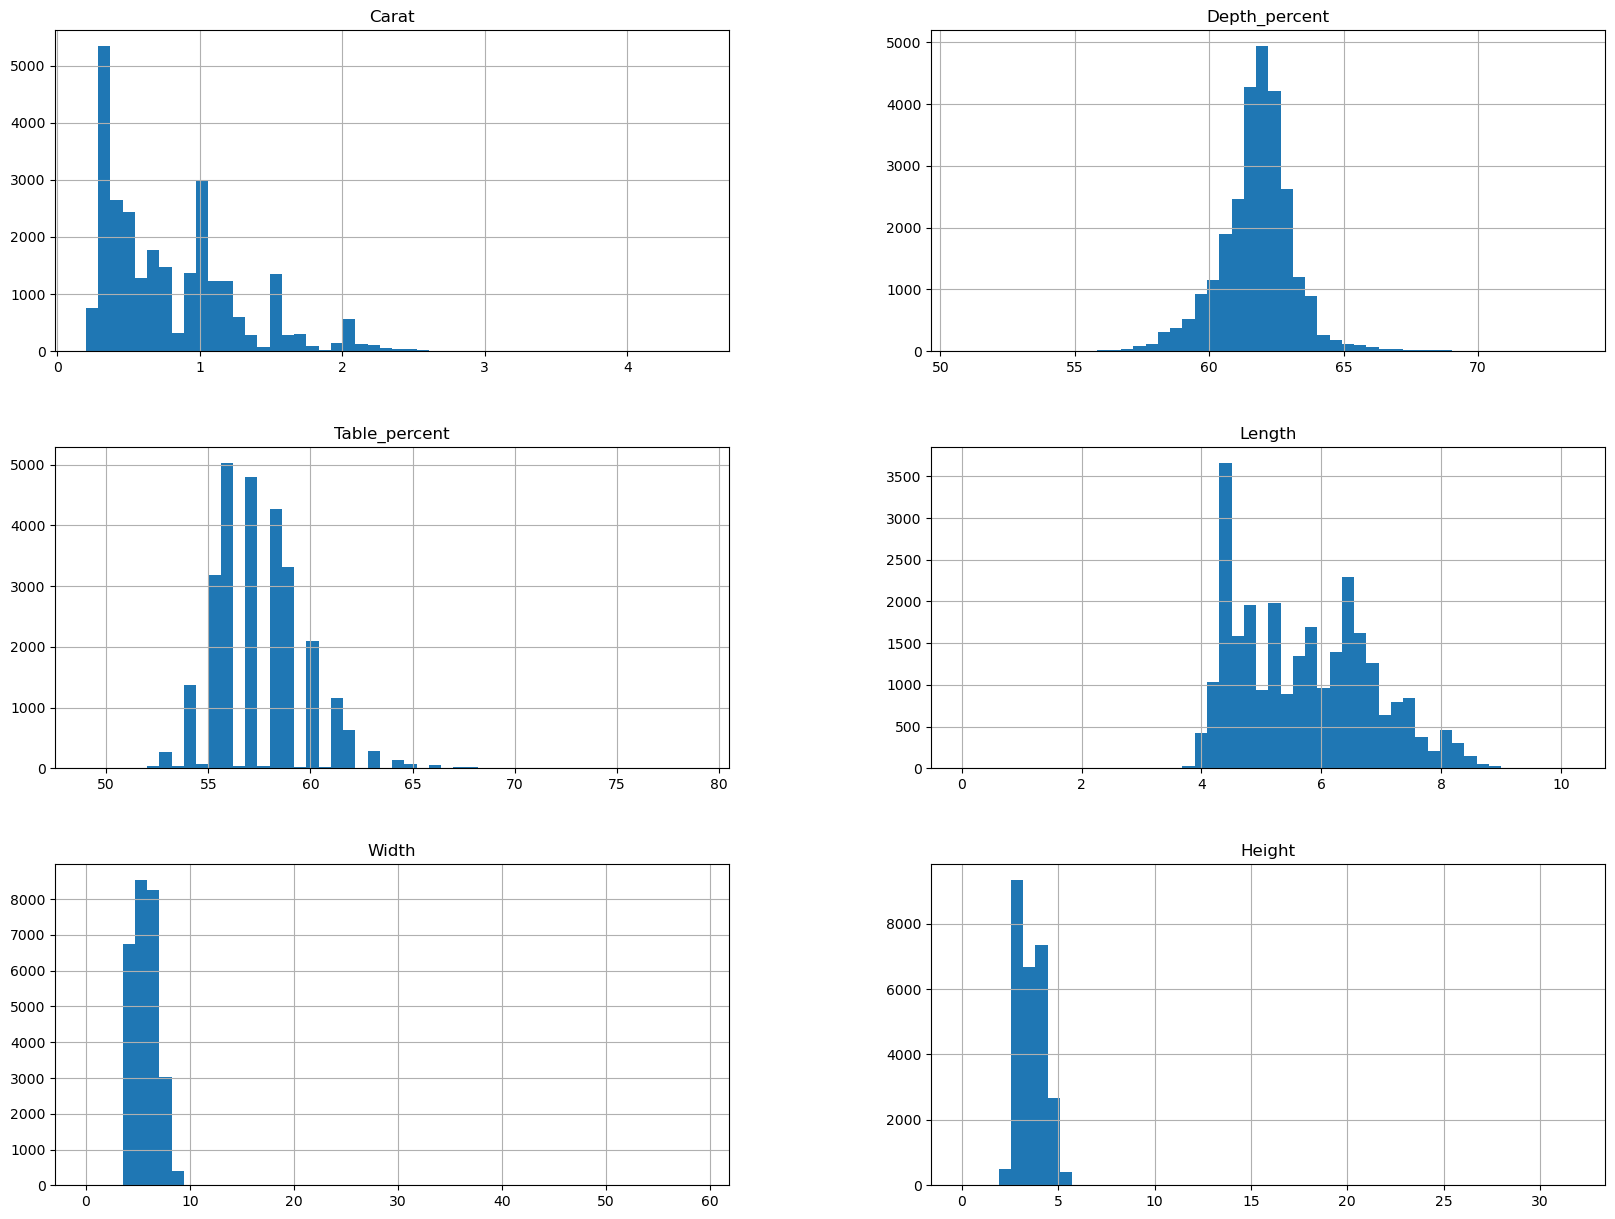

In [15]:
df.select(num_cols).toPandas().hist(bins=50,figsize=(20,15)) # Plotting histogram for all attributes
plt.show()

- Using median replacement for **'Length'**, **'Width'**, **'Height'**, and **'Table_percent'** is effective because these features have a very low percentage of outliers. The median is robust to outliers, ensuring that the central tendency of the data is preserved without being skewed by extreme values.

- Capping was chosen for **'Carat'** and **'Depth_percent'** due to their higher percentage of outliers (2.80% and 4.54%, respectively). Capping limits the influence of extreme values by setting them to a specified percentile, which helps in maintaining the overall distribution while reducing the impact of outliers on statistical analyses. This approach balances data integrity with the need to mitigate distortion from outliers.


In [16]:
#median replacement
for i in ['Length', 'Width', 'Height', 'Table_percent']:
    df = replace_outliers_median(df, i)

In [17]:
#upper bound lower bound replacement
for i in ['Carat', 'Depth_percent']:
    df = replace_outliers_capping(df, i)

#### Confirming Outlier Removal

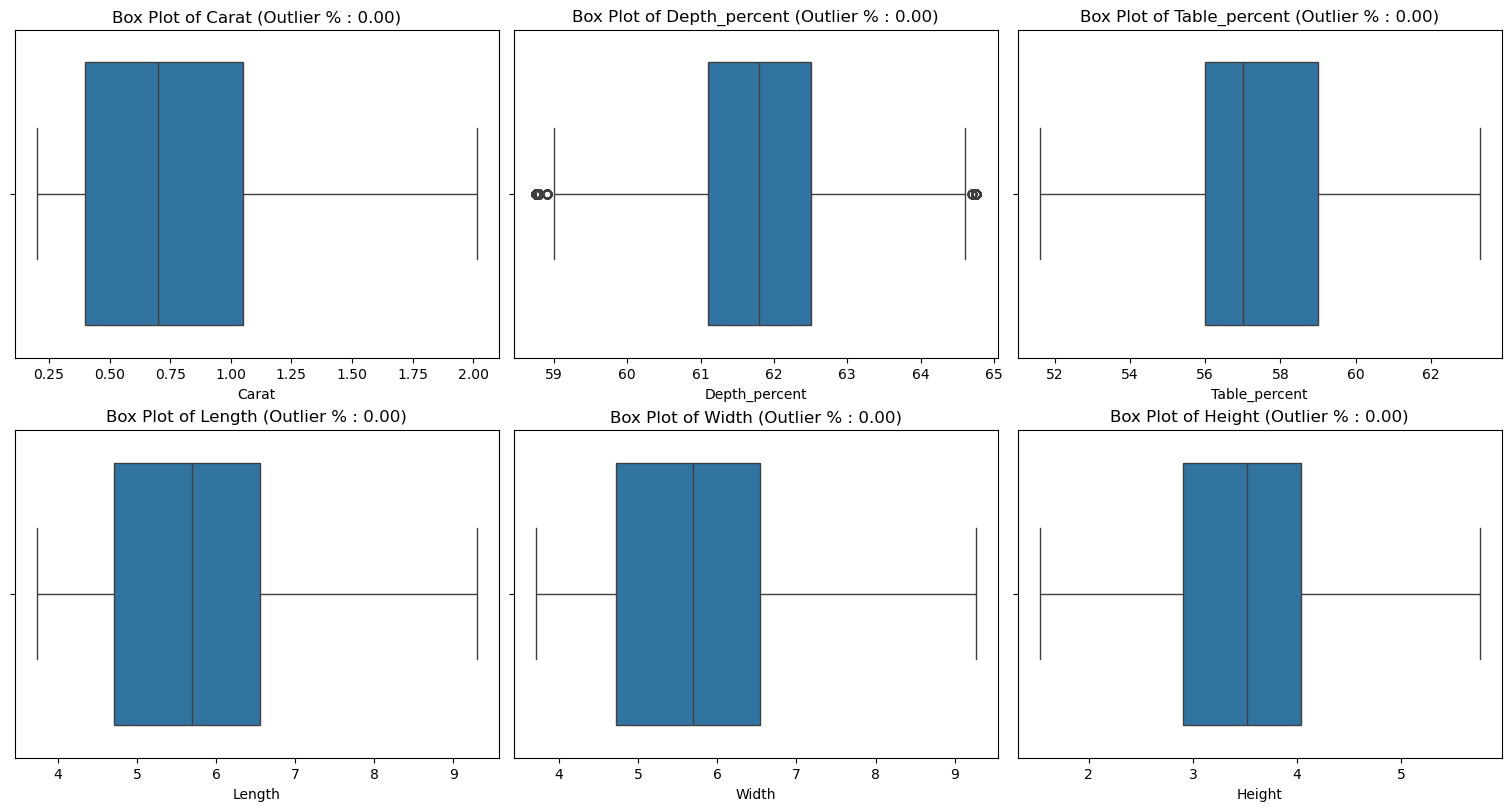

In [18]:
plot_outliers(df, num_cols)

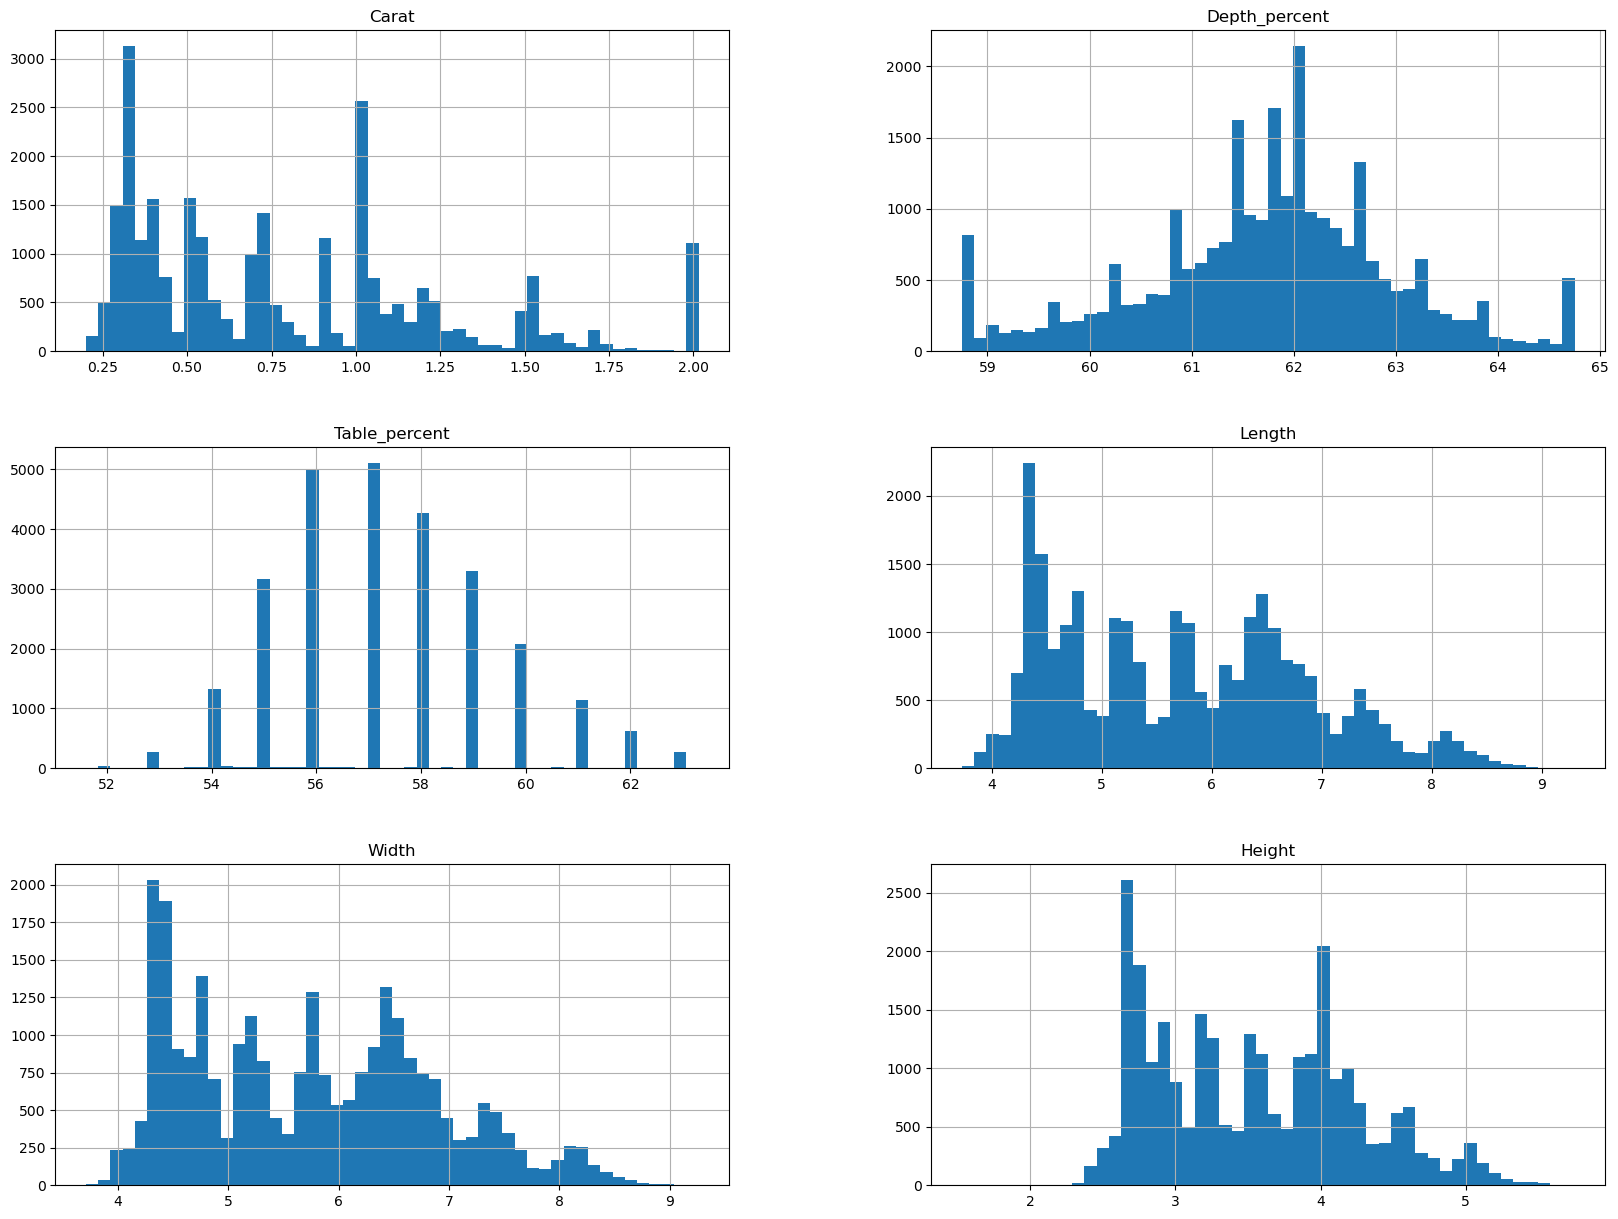

In [19]:
df.select(num_cols).toPandas().hist(bins=50,figsize=(20,15)) # Plotting histogram for all attributes
plt.show()

## 3. Categorical Value Distribution

- Present the distribution of values in the **Cut**, **Color**, and **Clarity** columns along with the percentages.


In [20]:
for i in ['Cut', 'Color', 'Clarity']:
    df.groupBy(i).count()\
        .orderBy(F.desc("count"))\
        .withColumn('%', (100*F.col('count')/df.count()))\
        .drop('count')\
        .show()

+---------+------------------+
|      Cut|                 %|
+---------+------------------+
|    Ideal|40.108280490970444|
|  Premium|25.583120109763787|
|Very Good|22.360663032595394|
|     Good| 9.051804056810175|
|     Fair|2.8961323098601994|
+---------+------------------+

+-----+------------------+
|Color|                 %|
+-----+------------------+
|    G|20.992323951496275|
|    E|  18.2333963733452|
|    F|17.536248006823154|
|    H| 15.21118403975229|
|    D|12.400341157711276|
|    I|10.275521934215893|
|    J| 5.350984536655913|
+-----+------------------+

+-------+------------------+
|Clarity|                 %|
+-------+------------------+
|    SI1|24.366818704342343|
|    VS2|22.616531316052953|
|    SI2| 16.96517966403382|
|    VS1|15.177809915823042|
|   VVS2| 9.385545296102643|
|   VVS1| 6.819445989542775|
|     IF|3.3151629769718545|
|     I1| 1.353506137130567|
+-------+------------------+



# **Part 3: Feature Engineering and Preprocessing**

## 1. Generate New Features

- Think critically about how you might improve the dataset by adding new features based on the existing columns. For example, you could explore relationships between multiple features or derive additional useful attributes.
- Create at least one new feature and explain why it might be useful for predicting the diamond's price.


### New Feature - Volume
- This feature captures a three-dimensional aspect of the diamond that weight alone cannot convey. It helps differentiate between diamonds that may weigh the same but have different appearances and values.


In [21]:
df = df.withColumn('Volume', F.col('Height')*F.col('Length')*F.col('Width'))
num_cols.append('Volume')

In [22]:
df.show(5)

+-----+---------+-----+-------+-------------+-------------+------+-----+------+-----+------------------+
|Carat|      Cut|Color|Clarity|Depth_percent|Table_percent|Length|Width|Height|Price|            Volume|
+-----+---------+-----+-------+-------------+-------------+------+-----+------+-----+------------------+
|  0.3|    Ideal|    E|    SI1|         62.1|         58.0|  4.27| 4.29|  2.66|  499|         48.726678|
| 0.33|  Premium|    G|     IF|         60.8|         58.0|  4.42| 4.46|   2.7|  984|53.225640000000006|
|  0.9|Very Good|    E|   VVS2|         62.2|         60.0|  6.04| 6.12|  3.78| 6289|        139.726944|
| 0.42|    Ideal|    F|    VS1|         61.6|         56.0|  4.82|  4.8|  2.96| 1082|          68.48256|
| 0.31|    Ideal|    F|   VVS1|         60.4|         59.0|  4.35| 4.43|  2.65|  779| 51.06682499999999|
+-----+---------+-----+-------+-------------+-------------+------+-----+------+-----+------------------+
only showing top 5 rows



## 2. Feature Scaling
- Based on the numerical features, determine whether normalization or standardization is required. Apply the appropriate technique if needed and justify your decision.


#### MinMax scaling (Normalization) effectively preserves the shape of the original data distribution, making it suitable for datasets that do not follow a Gaussian distribution. Most of the features here are not strictly normal, indicate that MinMax scaling maintains these shapes while normalizing. 

#### By scaling features to a uniform range (typically 0 to 1), it ensures that all features contribute equally to distance calculations in machine learning models. Additionally, the scaled values remain interpretable within this fixed range, facilitating easier comparison and understanding across different features without altering their inherent relationships.

#### Here, Minmax Scaling will be applied to the features after splitting the dataset into training and testing sets in order to prevent data leakage.

## 3. Relationship Between Features

- Perform a correlation analysis to identify relationships between numerical features and the Price.
- Comment on any strong correlations or patterns that you observe.


In [23]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def get_correlation_matrix_spark(df):
    # convert to vector column first
    dim = len(df.columns)
    cols = df.columns
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    
    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    matrix = matrix.collect()[0]['pearson(corr_features)'].values
    matrix = matrix.reshape((dim,dim))
    matrix_df = pd.DataFrame(matrix, columns = cols)
    matrix_df.index = cols

    plt.figure(figsize=(10, 8))

    # Plot the heatmap
    sns.heatmap(matrix_df, 
                annot=True,            # Displays the correlation values in the plot
                cmap='RdBu',           # Color scale for the heatmap
                center=0,              # Centering the colormap around 0
                vmin=-1, vmax=1,       # Setting the color bar limits
                linewidths=0.5,        # Adding space between squares
                fmt=".2f",             # Formatting the annotations
                square=True)           # Make the cells square-shaped

    # Add title
    plt.title("Correlation Matrix", size=16)

    # Show the plot
    plt.show()
    
    return

#### Plotting Correlation Matrix to identify highly correlated variables 

24/10/27 20:41:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


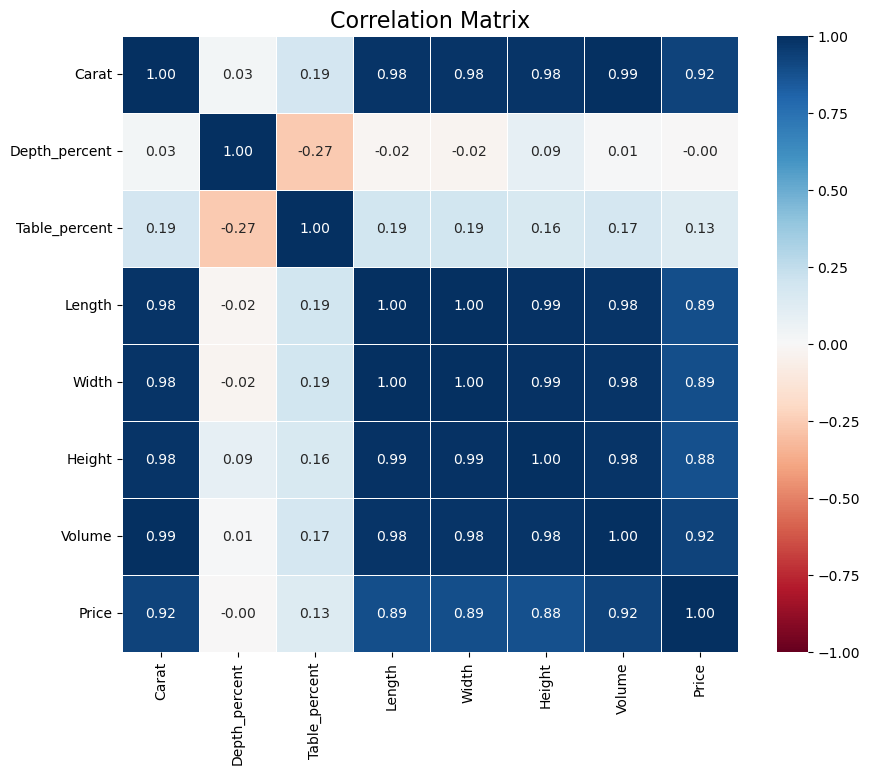

In [24]:
get_correlation_matrix_spark(df.select(num_cols + ['Price']))

- Removed the Length, Width, and Height features from the dataset since they can be represented by the Volume feature, a derived metric.
- It is not advisable to remove the Volume feature, even though it shows a high correlation with the Carat feature. Retaining the Volume feature is essential because it encapsulates significant information about the diamonds' physical attributes. The Volume feature can enhance the model's ability to predict the target variable.

In [25]:
num_cols.remove('Length')
num_cols.remove('Width')
num_cols.remove('Height')

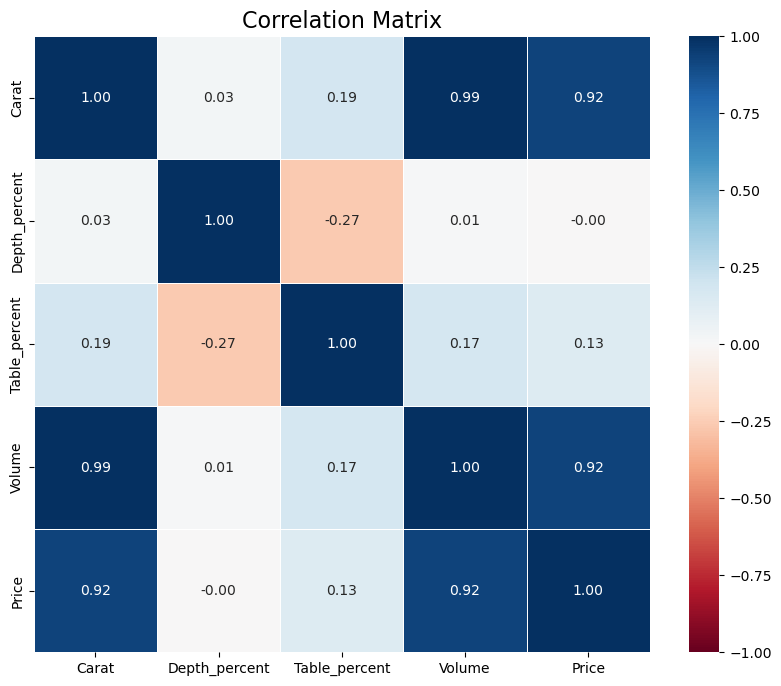

In [26]:
get_correlation_matrix_spark(df.select(num_cols + ['Price']))

# **Part 4: Regression Modeling**

## 1. Data Preprocessing for Modeling

- Convert the categorical columns (Cut, Color, and Clarity) to numerical values.
- Split the data into training and testing sets. Ensure that the split is done in a way that the target variable (Price) has an approximately equal mean across both sets.


In [27]:
price_min, price_max = df.select(F.min('Price')).collect()[0][0], df.select(F.max('Price')).collect()[0][0]
price_bins = np.linspace(0, 19000, 11).tolist()
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=price_bins, inputCol="Price", outputCol="Price_binned")
df_binned = bucketizer.transform(df)
df_binned = df_binned.withColumn('Price_binned', F.col('Price_binned').cast('int').cast('string'))
df_binned = df_binned.withColumn('id', F.monotonically_increasing_id())

fractions = {category: 0.75 for category in df_binned.select("Price_binned").distinct().rdd.flatMap(lambda x: x).collect()}
fractions

{'7': 0.75,
 '3': 0.75,
 '8': 0.75,
 '0': 0.75,
 '5': 0.75,
 '6': 0.75,
 '9': 0.75,
 '1': 0.75,
 '4': 0.75,
 '2': 0.75}

In [28]:
df_train = df_binned.sampleBy("Price_binned", fractions, seed=42)
df_test = df_binned.subtract(df_train)

In [29]:
df_train.count()/df_binned.count()

0.7501390588497052

In [30]:
df_train.count() + df_test.count()

26967

In [31]:
df_binned.count()

26967

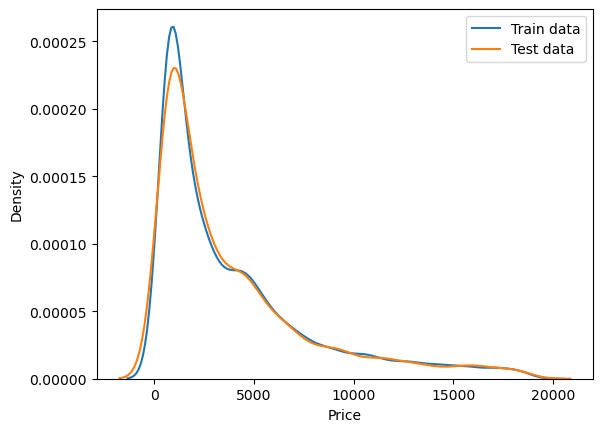

In [32]:
import seaborn as sns
ax = sns.kdeplot(df_train.select(['Price']).toPandas()['Price'],label='Train data')
sns.kdeplot(df_test.select(['Price']).toPandas()['Price'], ax=ax,label='Test data')
plt.legend()

#### The distribution of the target variable, "Price," in the train and test datasets appears to be well-matched. The means of the two datasets are very close.
#### This ensures similar distribution of the target variable across both sets.

#### Converting the categorical columns (Cut, Color, and Clarity) to numerical values.


In [33]:
from pyspark.ml.feature import StringIndexer
def index_categories(cat_cols, df_train, df_test):
    df_train_cat = df_train.select(cat_cols)
    df_test_cat = df_test.select(cat_cols)
    for i in cat_cols:
        indexer = StringIndexer(inputCol = i, outputCol = i.lower() + '_indexed')
        indexer = indexer.fit(df_train_cat)
        df_train_cat = indexer.transform(df_train_cat)
        df_test_cat = indexer.transform(df_test_cat)
    for i in cat_cols:
        df_train_cat = df_train_cat.drop(i)
        df_test_cat = df_test_cat.drop(i)
    return df_train_cat, df_test_cat

from pyspark.ml.feature import OneHotEncoder
def encode_categories(cat_cols, df_train, df_test):
    df_train_cat, df_test_cat = index_categories(cat_cols, df_train, df_test)
    encoder = OneHotEncoder(inputCols=df_train_cat.columns,
                            outputCols=[x + '_vector' for x in df_train_cat.columns])
    encoder = encoder.fit(df_train_cat)
    df_train_cat = encoder.transform(df_train_cat)
    df_test_cat = encoder.transform(df_test_cat)
    
    df_train_cat = df_train_cat.drop('cut_indexed', 'color_indexed', 'clarity_indexed')
    df_train_cat = df_train_cat.withColumn('id', F.monotonically_increasing_id())

    df_test_cat = df_test_cat.drop('cut_indexed', 'color_indexed', 'clarity_indexed')
    df_test_cat = df_test_cat.withColumn('id', F.monotonically_increasing_id())
    
    return df_train_cat, df_test_cat

In [34]:
df_train_cat, df_test_cat = encode_categories(['Cut', 'Color', 'Clarity'], df_train, df_test)

### Feature Scaling using minmax scaler (from part 3)

In [35]:
def vectorize(cols, df):
    vectorAssembler = VectorAssembler(inputCols = cols, outputCol = 'features')
    df_vectorized = vectorAssembler.transform(df.select(cols))
    return df_vectorized

In [36]:
from pyspark.ml.feature import MinMaxScaler
def scale_minmax(scaler_cols, df):
    df_vectorized = vectorize(scaler_cols, df)
    mm = MinMaxScaler(inputCol = 'features', outputCol = 'mm_scaled_features')
    mm = mm.fit(df_vectorized.select(['features']))
    df_scaled = mm.transform(df_vectorized.select(['features']))
    df_scaled = df_scaled.select('mm_scaled_features')
    df_trans = df_scaled.withColumn('id', F.monotonically_increasing_id())
    return df_trans, mm

In [37]:
from pyspark.ml.feature import StandardScaler
def scale_standard(scaler_cols, df):
    df_vectorized = vectorize(scaler_cols, df)
    sd = StandardScaler(inputCol = 'features', outputCol = 'sd_scaled_features', withMean = True)
    sd = sd.fit(df_vectorized.select(['features']))
    df_scaled = sd.transform(df_vectorized.select(['features']))
    df_scaled = df_scaled.select('sd_scaled_features')
    df_trans = df_scaled.withColumn('id', F.monotonically_increasing_id())
    return df_trans, sd

In [38]:
df_train_trans, num_scaler = scale_minmax(num_cols, df_train)

In [39]:
df_test_trans = vectorize(num_cols, df_test)
df_test_trans = num_scaler.transform(df_test_trans.select(['features']))
df_test_trans = df_test_trans.drop('features')
df_test_trans = df_test_trans.withColumn('id', F.monotonically_increasing_id())

In [40]:
df_train_trans.show()

+--------------------+---+
|  mm_scaled_features| id|
+--------------------+---+
|[0.05509641873278...|  0|
|[0.07162534435261...|  1|
|[0.12121212121212...|  2|
|[0.06060606060606...|  3|
|[0.45179063360881...|  4|
|[0.16528925619834...|  5|
|[0.06611570247933...|  6|
|[0.49586776859504...|  7|
|[0.16528925619834...|  8|
|[0.71625344352617...|  9|
|[0.06060606060606...| 10|
|[0.07713498622589...| 11|
|[0.44628099173553...| 12|
|[0.38567493112947...| 13|
|[0.46280991735537...| 14|
|[0.11019283746556...| 15|
|[0.72727272727272...| 16|
|[0.25344352617079...| 17|
|[0.71625344352617...| 18|
|[0.07713498622589...| 19|
+--------------------+---+
only showing top 20 rows



In [41]:
def join_nums_cats(df, df_cat, df_trans):
    df_final = df_trans.join(df_cat, on = ['id'], how = 'inner')\
                    .join(df.select('Price').withColumn('id', F.monotonically_increasing_id()), on = ['id'], how = 'inner')\
                    .drop('id')
    return df_final

In [42]:
df_train_final = join_nums_cats(df_train, df_train_cat, df_train_trans)
df_test_final = join_nums_cats(df_test, df_test_cat, df_test_trans)

In [43]:
final_assembler = VectorAssembler(inputCols = df_train_final.drop('Price').columns,
                                 outputCol = 'features')
df_train_final = final_assembler.transform(df_train_final)
df_train_final = df_train_final.select(['Price', 'features'])

In [44]:
final_assembler = VectorAssembler(inputCols = df_test_final.drop('Price').columns,
                                 outputCol = 'features')
df_test_final = final_assembler.transform(df_test_final)
df_test_final = df_test_final.select(['Price', 'features'])

In [45]:
df_train_final.show()

+-----+--------------------+
|Price|            features|
+-----+--------------------+
|  499|(21,[0,1,2,3,4,9,...|
|  984|(21,[0,1,2,3,5,8,...|
| 1082|(21,[0,1,2,3,4,10...|
|  779|(21,[0,1,2,3,4,10...|
| 9502|(21,[0,1,2,3,4,12...|
| 1415|(21,[0,1,2,3,5,9,...|
|  637|(21,[0,1,2,3,4,9,...|
| 6468|(21,[0,1,2,3,5,12...|
| 1932|(21,[0,1,2,3,7,9,...|
|10644|(21,[0,1,2,3,8,15...|
|  544|(21,[0,1,2,3,4,8,...|
|  650|(21,[0,1,2,3,4,8,...|
| 7127|(21,[0,1,2,3,4,12...|
| 3567|(21,[0,1,2,3,7,12...|
|10984|(21,[0,1,2,3,5,12...|
| 1080|(21,[0,1,2,3,4,10...|
| 8631|(21,[0,1,2,3,4,12...|
| 1609|(21,[0,1,2,3,4,11...|
| 7187|(21,[0,1,2,3,5,11...|
|  803|(21,[0,1,2,3,4,12...|
+-----+--------------------+
only showing top 20 rows



## 2. Regression Models

- Train two regression models (choose from any suitable algorithms such as Linear Regression, Decision Tree, Random Forest, etc.) to predict the Price of the diamond.


#### Linear Regression Model Training

In [46]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', 
                      labelCol = 'Price',
                     predictionCol="Price_pred")
lr = lr.fit(df_train_final)
train_act_pred_lr = lr.transform(df_train_final)
test_act_pred_lr = lr.transform(df_test_final)

24/10/27 20:41:37 WARN Instrumentation: [37630546] regParam is zero, which might cause numerical instability and overfitting.
24/10/27 20:41:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


#### Decision Tree Regression Model Training

In [47]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol = 'features',
                      labelCol = 'Price',
                     predictionCol="Price_pred")
dt = dt.fit(df_train_final)
train_act_pred_dt = dt.transform(df_train_final)
test_act_pred_dt = dt.transform(df_test_final)

## 3. Model Evaluation

- Evaluate the models using appropriate performance metrics. 
- Discuss the performance of the models and which one performed better in predicting the diamond prices.


In [48]:
from pyspark.ml.evaluation import RegressionEvaluator
def get_eval_metric(metric_type, actual_pred):
    for metric_type in ['rmse', 'mse', 'r2', 'mae', 'var']:
        evaluator = RegressionEvaluator(labelCol="Price", predictionCol="Price_pred", metricName = metric_type)
        metric_value = evaluator.evaluate(actual_pred)
        print("({}) : {:.3f}".format(metric_type, metric_value))
    return

ERROR! Session/line number was not unique in database. History logging moved to new session 7


#### Linear Regression Performance

In [49]:
get_eval_metric(i, train_act_pred_lr)

(rmse) : 1146.060
(mse) : 1313454.170
(r2) : 0.919
(mae) : 819.831
(var) : 14886535.963


In [50]:
get_eval_metric(i, test_act_pred_lr)

(rmse) : 1181.116
(mse) : 1395034.546
(r2) : 0.914
(mae) : 832.062
(var) : 14716634.736


#### Decision Tree Regression Performance

In [51]:
get_eval_metric(i, train_act_pred_dt)

(rmse) : 1271.388
(mse) : 1616427.400
(r2) : 0.900
(mae) : 692.684
(var) : 14583562.732


In [52]:
get_eval_metric(i, test_act_pred_dt)

(rmse) : 1323.345
(mse) : 1751242.615
(r2) : 0.892
(mae) : 704.295
(var) : 14426742.677


## Model Comparison

| Metric       | Training Set (LR) | Test Set (LR) | Training Set (DT) | Test Set (DT) |
|--------------|-------------------|----------------|--------------------|----------------|
| RMSE         | 1146.060          | 1181.116       | 1271.388           | 1323.345       |
| MSE          | 1313454.170       | 1395034.546    | 1616427.400        | 1751242.615    |
| R²           | 0.919             | 0.914          | 0.900              | 0.892          |
| MAE          | 819.831           | 832.062        | 692.684            | 702.792        |
| Variance     | 14886535.963      | 14716634.736   | 14583562.732       | 14426742.677   |


- **Accuracy (R²)**: The Linear Regression model has a higher R² value on both training (0.919) and test sets (0.914) compared to the Decision Tree model (0.900 on training and 0.892 on test). This indicates that the Linear Regression model explains a greater proportion of the variance in the data.
  
- **Error Metrics (RMSE, MSE, MAE)**: The Linear Regression model has lower RMSE, MSE, and slightly higher MAE on both sets compared to the Decision Tree model, indicating better overall prediction accuracy.
  
- **Variance**: Both models have similar variance values, but the Linear Regression model slightly outperforms in terms of consistency across datasets.

## Conclusion

The Linear Regression model performs better in predicting diamond prices, as evidenced by its higher R² values and lower RMSE and MSE on both training and test datasets. It provides a more accurate and reliable prediction compared to the Decision Tree Regression model for this particular task.
